In [207]:
# install spell checker
#!pip install jupyter_contrib_nbextensions
#!jupyter contrib nbextension install --user
#!jupyter nbextension enable spellchecker/main

In [219]:
# for better EDA I allow Jupyter to print also intermediate results
# -----------------------------------------------------------------

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign" # Options 'all', 'last', 'last_expr', 'none', 'last_expr_or_assign'

# First Project - EDA #

### The data ###
- The datasets can be found in the respective folders in this repository.
- Each folder contains the dataset either as a .csv or .txt file. The description of
the column names can be found in the column_names.md files.
- The column names may NOT be clear at times:


### Tasks for you ###
1. Create a new repo and a new virtual environment.
2. Through EDA/statistical analysis above please come up with AT LEAST 3
insights/recommendations for your stakeholder.
If you use linear regression in the exploration phase remember that R2
 close
to 1 is good.
3. Then, model this dataset with a multivariate linear regression to predict
b. For US Bank Wages: The salary (or log(salary)) as accurately as
possible. Note you can take either the perspective of an applicant or
company.
i. Split the dataset into a train and a test set. (use the sklearn split
method
https://scikit-learn.org/stable/modules/generated/sklearn.mod
el_selection.train_test_split.html )
ii. Use Root Mean Squared Error (RMSE) as your metric of success
and try to minimize this score on your test data.

### The Deliverables ###
1. A well documented Jupyter Notebook (see here for an example) containing
the code you've written for this project and comments explaining it. This work
will need to be pushed to your GitHub repository in order to submit your
project (latest upload: 18.02.2020 12:00). Do not push all the analysis... just
the analysis that is relevant!
2. A Python script for training the model, printing out the model statistics and
saving the model.
3. An organized README.md file in the GitHub repository that describes the
contents of the repository. This file should be the source of information for
navigating through the repository.
4. A short Keynote/PowerPoint/Google Slides/Jupyter slides presentation
giving a high-level overview of your methodology and recommendations for
non-technical stakeholders. The duration of the presentation should be 10
minutes, then the discussion will continue for 5 minutes. Also put your slides
(delivered as a PDF export) on Github to get a well-rounded project

# The Stackholder #

Is a NGO that works on the integration of female war-refugees into society.

### The Task ###
- The NGO is suspecting that a certain bank does not follow their own code of conduct.

### The Questions ###
- What is the salary based on in this bank?
- Is there an difference in pay between male and female employees?
- Would females with a minority background have the same chances for a fair salery as non-minority women?

### The Hypothesis ###
1. Salary depends on education.
- H0: B_EDUC = 0
- H1: B_EDUC > 0
2. Salary depends on gender.
- H0: B_GENDER = 0
- H1: B_GENDER > 0
3. Salary depends on minority group membership.
- H0: B_MINORITY = 0
- H1: B_MINORITY > 0

For later -> Answer

We would expect mpg to decrease by 0.047 as horsepower goes up by 1, holding weight constant.

We would expect mpg to decrease by 0.006 as weight increases by 1, holding horsepower constant,


# Set up Python

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy import stats
import seaborn as sns
#import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline

# Load Data

In [221]:
# loading project data
data = pd.read_csv('us_bank_wages/us_bank_wages.txt', delimiter='\t')
list(data.columns)
data.drop('Unnamed: 0', axis=1, inplace=True)

In [225]:
# print descritive information of loaded data set
data.shape
data.head(3)

,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT
0,57000,15,27000,1,0,3
1,40200,16,18750,1,0,1
2,21450,12,12000,0,0,1


In [226]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SALARY    474 non-null    int64
 1   EDUC      474 non-null    int64
 2   SALBEGIN  474 non-null    int64
 3   GENDER    474 non-null    int64
 4   MINORITY  474 non-null    int64
 5   JOBCAT    474 non-null    int64
dtypes: int64(6)
memory usage: 22.3 KB


,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,34419.567511,13.491561,17016.086498,0.544304,0.219409,1.411392
std,17075.661465,2.884846,7870.638154,0.498559,0.414284,0.773201
min,15750.000000,8.000000,9000.000000,0.000000,0.000000,1.000000
25%,24000.000000,12.000000,12487.500000,0.000000,0.000000,1.000000
50%,28875.000000,12.000000,15000.000000,1.000000,0.000000,1.000000
75%,36937.500000,15.000000,17490.000000,1.000000,0.000000,1.000000
max,135000.000000,21.000000,79980.000000,1.000000,1.000000,3.000000


# Data Cleaning

In [227]:
# checking for NaN 
data.isnull().sum()
data.isnull().values.any()

# to drop all NaN values
#data.dropna(inplace=True)
# eaxmple to fill NaN
#data['SALBEGIN'].fillna(df['SALBEGIN'].mean(), inplace=True)

# de-skewing - explaination: the SALERY colmuns are right skewed and to compensate for that I use log() 
# 20210216 - I don not use log() for now do avoid unit changes
#data.eval('SALARY = log(SALARY)', inplace = True)
#data.eval('SALBEGIN = log(SALBEGIN)', inplace = True)

# delta is not giving any additional information - I will not use it any more (2021-02-16)
#data.eval('DELTA = SALARY - SALBEGIN', inplace = True) # delta between start salery and salery
#data

False

# Data Prep

In [228]:
# spliting data into train and test data

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True) # random_state = seed !!

train_X = train[['EDUC', 'SALBEGIN', 'GENDER', 'MINORITY', 'JOBCAT']]
train_Y = train['SALARY']

test_X = test[['EDUC', 'SALBEGIN', 'GENDER', 'MINORITY', 'JOBCAT']]
test_Y = test['SALARY']

train.shape, test.shape

((379, 6), (95, 6))

In [229]:
# craeting dummy vars - avoiding dummy-trap
if False:
    dummy = pd.get_dummies(train['JOBCAT'], prefix='JOBCAT', drop_first=True)

    train = pd.concat([train, dummy], axis=1)

    if 'JOBCAT' in train.columns.to_list():
        train.drop('JOBCAT', axis=1, inplace=True)
    if 'Unnamed: 0' in train.columns.to_list():
        train.drop('Unnamed: 0', axis=1, inplace=True)

    dummy = pd.get_dummies(train['EDUC'], prefix='EDUC', drop_first=True)

    train = pd.concat([train, dummy], axis=1)

    if 'EDUC' in train.columns.to_list():
        train.drop('EDUC', axis=1, inplace=True)
    if 'Unnamed: 0' in train.columns.to_list():
        train.drop('Unnamed: 0', axis=1, inplace=True)

# EDA Start

## Column Names and descriptions for US Bank Wages data set
* **SALARY**:  current yearly salary in dollar [\$]
* **EDUC**: education (number of finished years)
* **SALBEGIN**: yearly salary at employee's first position at same bank in dollars [\$]
* **GENDER**: gender variable (0 for females, 1 for males)
* **MINORITY**: minority variable (0 for non-minorities, 1 for minorities)
* **JOBCAT**: - job category (1 for administrative jobs, 2 for custodial jobs, 3 for management jobs)

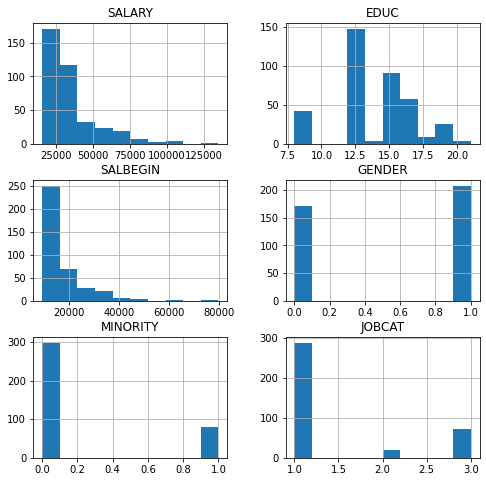

In [230]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
train.hist(ax = ax);

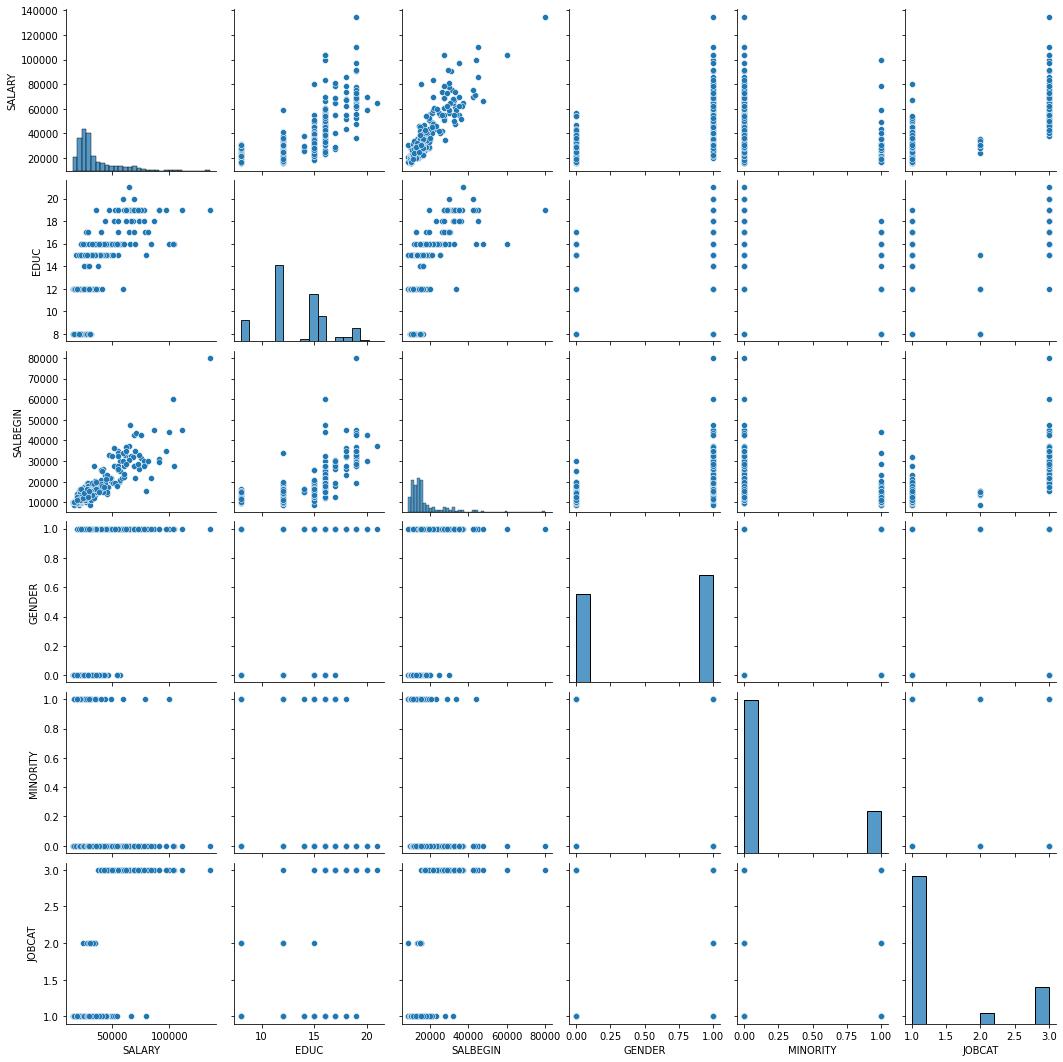

In [193]:
sns.pairplot(train)

<AxesSubplot:>

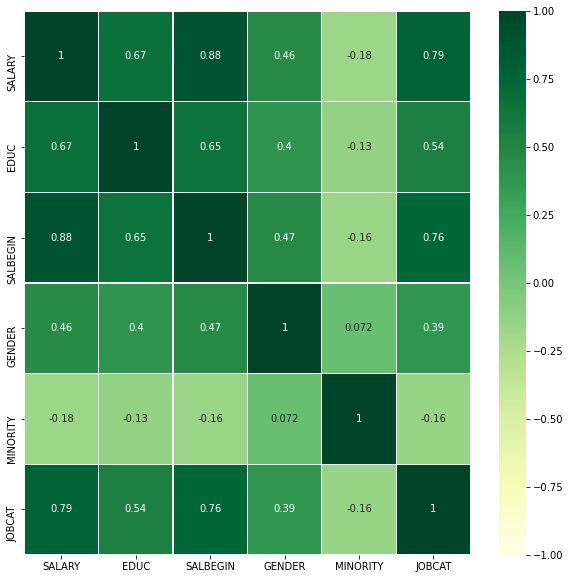

In [233]:
df_kor = train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_kor, vmin=-1, vmax=1, cmap="YlGn", annot=True, linewidth=0.1)

In [19]:
# EDA by single column

cols = train.columns.to_list()
cols.remove('SALARY')
cols
for col in cols:
    print(col)
    print('\t    rsquared:',smf.ols(formula=f'SALARY ~ '+col, data=train).fit().rsquared)
    print('\trsquared_adj:',smf.ols(formula=f'SALARY ~ '+col, data=train).fit().rsquared_adj)
    print('\t    f_pvalue:',smf.ols(formula=f'SALARY ~ '+col, data=train).fit().f_pvalue)

['EDUC', 'SALBEGIN', 'GENDER', 'MINORITY', 'JOBCAT']

EDUC
	    rsquared: 0.4492348651516894
	rsquared_adj: 0.44777394967463824
	    f_pvalue: 9.078725684143804e-51
SALBEGIN
	    rsquared: 0.7812131394829096
	rsquared_adj: 0.7806328029828643
	    f_pvalue: 1.8229693004773198e-126
GENDER
	    rsquared: 0.2109923305655248
	rsquared_adj: 0.20889947202591086
	    f_pvalue: 3.523498859191208e-21
MINORITY
	    rsquared: 0.0314140275695004
	rsquared_adj: 0.02884483400867688
	    f_pvalue: 0.000527120608253628
JOBCAT
	    rsquared: 0.6186414418746766
	rsquared_adj: 0.6176298807125404
	    f_pvalue: 6.286696641267465e-81


Result: It seems that SALBEGIN has a high influence on SALARY 

In [234]:
# check time-cost for model computation

f = 'SALARY ~ SALBEGIN + GENDER + C(MINORITY) + C(JOBCAT) + C(EDUC)'
smf.ols(formula=f, data=train).fit().rsquared_adj
%timeit smf.ols(formula=f, data=train).fit().rsquared_adj

9.51 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [235]:
# define function for brute force computation of all models
def find_best_model(var):
    r = {}
    for t in var:
        f = 'SALARY ~ ' + ' + '.join(t)
        m = smf.ols(formula=f, data=train).fit()
        r[m.rsquared_adj] = f # m.rsquared, m.f_pvalue, np.sqrt(m.mse_resid)
    return r

In [236]:
# generate column combinations - to check various models

var = []
columns = ['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)']
for i in range(len(columns)):
    # remove first
    cols = columns[i+1:]
    # add first to end
    cols += columns[:i+1]
    #print(cols)
    
    for i in range(len(cols)):
        if not [cols[i]] in var:
            var.append([cols[i]])
            
        c = cols.copy()
        c.remove(cols[i])
        while len(c):
            if not sorted([x for x in c]) in var:
                var.append(sorted([x for x in c]))
            x = c.pop() # x is only used to have less print-output in JL
            
sorted(var)

[['C(EDUC)'],
 ['C(EDUC)', 'C(JOBCAT)'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)', 'GENDER'],
 ['C(EDUC)', 'C(JOBCAT)', 'C(MINORITY)', 'SALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'GENDER'],
 ['C(EDUC)', 'C(JOBCAT)', 'GENDER', 'SALBEGIN'],
 ['C(EDUC)', 'C(JOBCAT)', 'SALBEGIN'],
 ['C(EDUC)', 'C(MINORITY)'],
 ['C(EDUC)', 'C(MINORITY)', 'GENDER'],
 ['C(EDUC)', 'C(MINORITY)', 'GENDER', 'SALBEGIN'],
 ['C(EDUC)', 'C(MINORITY)', 'SALBEGIN'],
 ['C(EDUC)', 'GENDER'],
 ['C(EDUC)', 'GENDER', 'SALBEGIN'],
 ['C(EDUC)', 'SALBEGIN'],
 ['C(JOBCAT)'],
 ['C(JOBCAT)', 'C(MINORITY)'],
 ['C(JOBCAT)', 'C(MINORITY)', 'GENDER'],
 ['C(JOBCAT)', 'C(MINORITY)', 'GENDER', 'SALBEGIN'],
 ['C(JOBCAT)', 'C(MINORITY)', 'SALBEGIN'],
 ['C(JOBCAT)', 'GENDER'],
 ['C(JOBCAT)', 'GENDER', 'SALBEGIN'],
 ['C(JOBCAT)', 'SALBEGIN'],
 ['C(MINORITY)'],
 ['C(MINORITY)', 'GENDER'],
 ['C(MINORITY)', 'GENDER', 'SALBEGIN'],
 ['C(MINORITY)', 'SALBEGIN'],
 ['GENDER'],
 ['GENDER', 'SALBEGIN'],
 ['SALBEGI

In [238]:
# run brute force model computation
model_fit_result = find_best_model(var)

# list model fittings - top 10
model_fit_result_list = sorted(model_fit_result.keys())[-11:]
for fit in model_fit_result_list:
    print('rsquared_adj:', fit, '\t<-', model_fit_result[fit])

rsquared_adj: 0.8082399293083553 	<- SALARY ~ C(EDUC) + SALBEGIN
rsquared_adj: 0.8084254256228924 	<- SALARY ~ C(EDUC) + C(MINORITY) + SALBEGIN
rsquared_adj: 0.8099951231848639 	<- SALARY ~ C(EDUC) + GENDER + SALBEGIN
rsquared_adj: 0.8107492238448184 	<- SALARY ~ C(EDUC) + C(MINORITY) + GENDER + SALBEGIN
rsquared_adj: 0.8154961818637975 	<- SALARY ~ C(JOBCAT) + C(MINORITY) + SALBEGIN
rsquared_adj: 0.8157848960520228 	<- SALARY ~ C(JOBCAT) + SALBEGIN
rsquared_adj: 0.818790245414134 	<- SALARY ~ C(JOBCAT) + GENDER + SALBEGIN
rsquared_adj: 0.8187965885289206 	<- SALARY ~ C(JOBCAT) + C(MINORITY) + GENDER + SALBEGIN
rsquared_adj: 0.8255631713443903 	<- SALARY ~ C(EDUC) + C(JOBCAT) + C(MINORITY) + SALBEGIN
rsquared_adj: 0.8256204234943031 	<- SALARY ~ C(EDUC) + C(JOBCAT) + SALBEGIN
rsquared_adj: 0.8262946570863963 	<- SALARY ~ C(EDUC) + C(JOBCAT) + GENDER + SALBEGIN


In [267]:
# choosing: the 2nd best, because is has one coef. less 
#   reason: there seems to be some influence of the GENDER but it appears to be quite small (per thousand range)
# rsquared_adj: 0.8256204234943031 	<- SALARY ~ C(EDUC) + C(JOBCAT) + SALBEGIN
# rsquared_adj: 0.8262946570863963 	<- SALARY ~ C(EDUC) + C(JOBCAT) + GENDER + SALBEGIN

f = 'SALARY ~ C(EDUC) + C(JOBCAT) + SALBEGIN' 

train_model_fit = smf.ols(formula=f, data=train).fit()
#model.summary()
#model.params['Intercept']
train_model_prediction = train_model_fit.predict()
train_model_fit.params
#learn_prediction

Intercept          6628.670206
C(EDUC)[T.12]      1643.783204
C(EDUC)[T.14]      3633.815913
C(EDUC)[T.15]      4707.838260
C(EDUC)[T.16]      6615.923640
C(EDUC)[T.17]     10941.830944
C(EDUC)[T.18]      8430.570609
C(EDUC)[T.19]     10289.739317
C(EDUC)[T.20]       -10.270960
C(EDUC)[T.21]      -937.772070
C(JOBCAT)[T.2]     3966.086703
C(JOBCAT)[T.3]    11243.592625
SALBEGIN              1.281747
dtype: float64

No handles with labels found to put in legend.


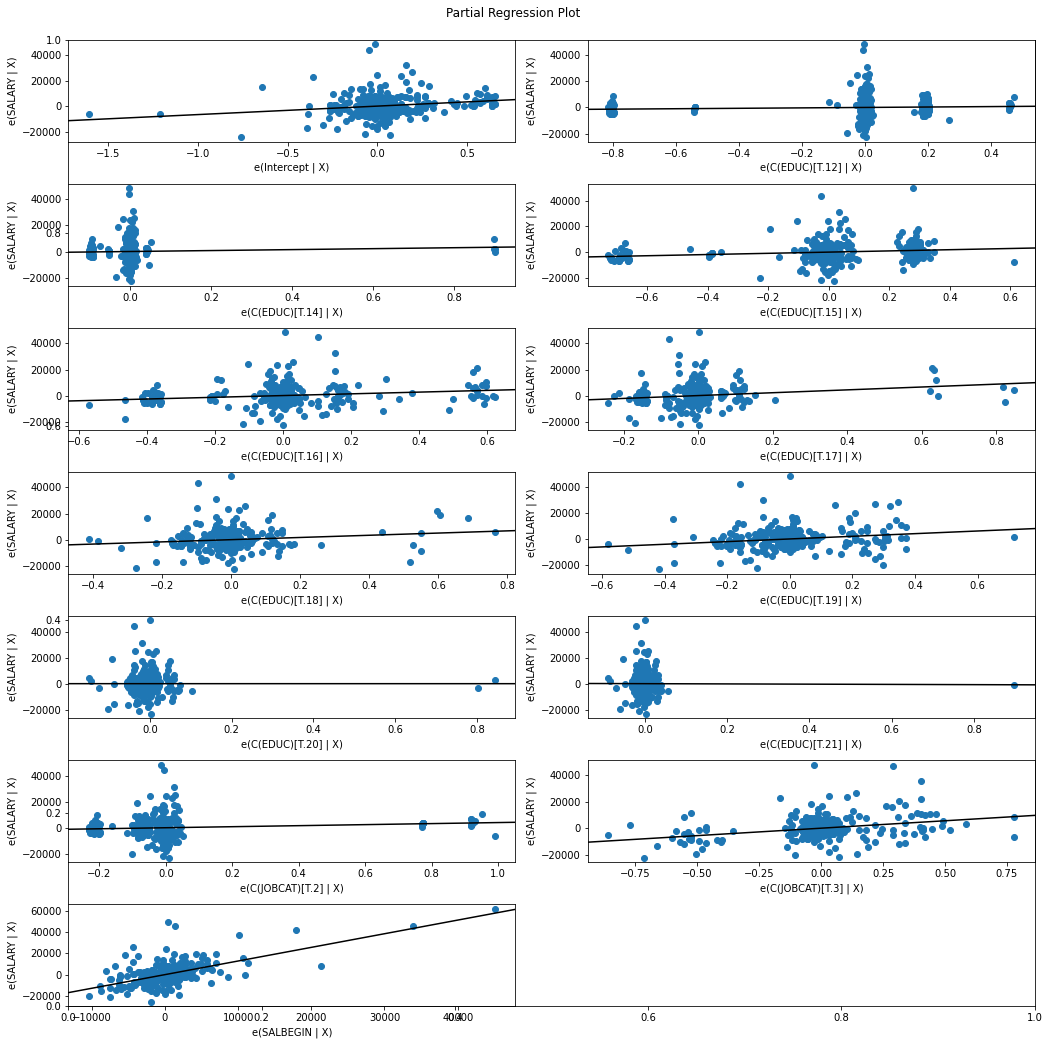

In [268]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics.regressionplots import plot_partregress_grid
prstd, iv_l, iv_u = wls_prediction_std(train_model_fit)

fig, ax = plt.subplots(figsize=(15,15))

plot_partregress_grid(train_model_fit, fig=fig)
#ax.plot(train_X, train_Y, 'o', label=train_X.columns.to_list())
#ax.plot(train_X, y_true, 'b-', label="True")
#ax.plot(train_X, model.fittedvalues, 'r--.', label="OLS")
#ax.plot(train_X, iv_u, 'r--')
#ax.plot(train_X, iv_l, 'r--')
ax.legend(loc='best');

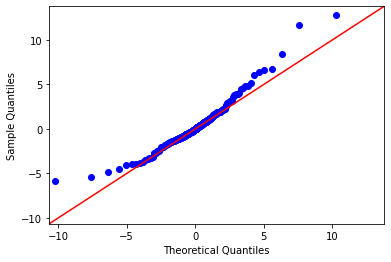

In [272]:
import statsmodels.api as sm
from matplotlib import pyplot as plt

res = train_model_fit.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

GENDER: gender variable (0 for females, 1 for males)
MINORITY: minority variable (0 for non-minorities, 1 for minorities)

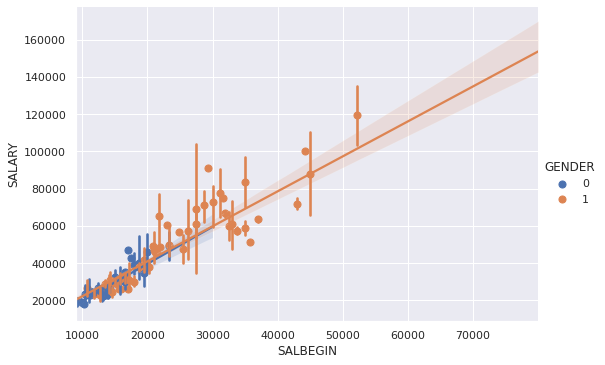

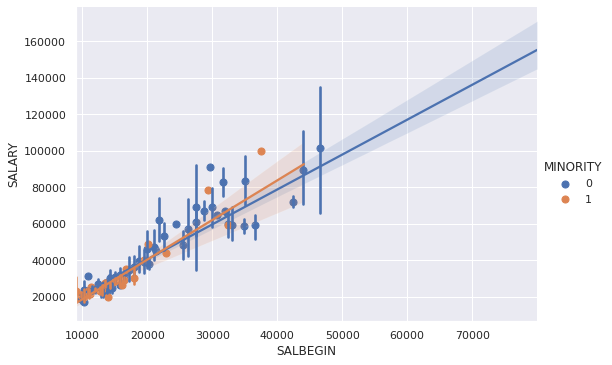

In [299]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(color_codes=True)
#tips = sns.load_dataset("tips")
#sns.regplot(x="SALBEGIN", y="SALARY", data=train);
sns.lmplot(x="SALBEGIN", y="SALARY", hue="GENDER", data=train, x_bins=int(len(list(train_Y))/3), height=4, aspect=2)
sns.lmplot(x="SALBEGIN", y="SALARY", hue="MINORITY", data=train, x_bins=int(len(list(train_Y))/3), height=4, aspect=2)
#g = sns.lmplot(x="SALBEGIN", y="SALARY", hue="GENDER", data=train);
#sns.lmplot(x="SALBEGIN", y="SALARY", hue="GENDER", data=train, x_estimator=np.mean)
#sns.regplot(x="SALBEGIN", y=train_Y, data=train_model_fit)
#sns.lmplot(x="total_bill", y="tip", data=tips)
#sns.lmplot(x="size", y="tip", data=tips)
#sns.lmplot(x="size", y="tip", data=tips, x_estimator=np.mean)
#anscombe = sns.load_dataset("anscombe")
#sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'I'"), ci=None, scatter_kws={"s": 80})

In [125]:
train_X.groupby(['MINORITY']).sum().reset_index().plot(kind='pie', y='SALARY')
train_X.groupby(['GENDER']).sum().reset_index().plot(kind='pie', y='SALARY')
train_X.groupby(['JOBCAT']).sum().reset_index().plot(kind='pie', y='SALARY')
#train.groupby(['GENDER','MINORITY']).sum().reset_index().plot(kind='hist')
#train.groupby(['SALARY','MINORITY']).mean().reset_index().plot(kind='hist')
#train.groupby(['SALARY','GENDER']).mean().reset_index().plot(kind='hist')
#train.groupby(['SALARY','JOBCAT']).mean().reset_index().plot(kind='hist')

In [192]:
from matplotlib import pyplot as plt

plt.subplot(211)
plt.pie(train_X['MINORITY'].values_counts())
plt.subplot(212)
plt.pie(train_X.groupby(['GENDER']).sum().reset_index())
plt.show()

<AxesSubplot:>

([<matplotlib.patches.Wedge at 0x7f44e777bee0>,
 [Text(1.0991727477423276, 0.04265290870012795, ''),
  Text(1.0966922352353066, 0.08524166337294958, ''),
  Text(1.0925621934054306, 0.12770220648491118, ''),
  Text(1.0867888342280232, 0.1699706733448284, ''),
  Text(1.0867888342280232, 0.1699706733448284, ''),
  Text(1.0867888342280232, 0.1699706733448284, ''),
  Text(1.0867888342280232, 0.1699706733448284, ''),
  Text(1.0867888342280232, 0.1699706733448284, ''),
  Text(1.0867888342280232, 0.1699706733448284, ''),
  Text(1.0867888342280232, 0.1699706733448284, ''),
  Text(1.0793808413838373, 0.21198348816245002, ''),
  Text(1.070349357197973, 0.2536774596724868, ''),
  Text(1.070349357197973, 0.2536774596724868, ''),
  Text(1.0597079658807629, 0.29498987618027867, ''),
  Text(1.0474726730958284, 0.3358585998861422, ''),
  Text(1.0474726730958284, 0.3358585998861422, ''),
  Text(1.0474726730958284, 0.3358585998861422, ''),
  Text(1.0474726730958284, 0.3358585998861422, ''),
  Text(1.0474

<AxesSubplot:>

ValueError: x must be 1D

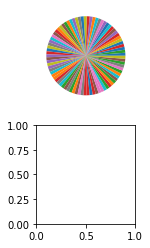

In [192]:
#%% 2 plot with plt
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('2 x 3 plot')

sns.lineplot(ax=axes[0, 0],  x=x, y=y)
sns.lineplot(ax=axes[0, 1],  x=x, y=y)
sns.lineplot(ax=axes[0, 2],  x=x, y=y)
sns.lineplot(ax=axes[1, 0],  x=x, y=y)
sns.lineplot(ax=axes[1, 1],  x=x, y=y)
sns.lineplot(ax=axes[1, 2],  x=x, y=y)

axes[0,0].set_title('sub fig 0 0')
axes[1,1].set_title('sub fig 1 1')
axes[1,2].set_title('sub fig 1 2')

#Note: to increase the size of all the labels in the same time, a simple solution is to use:
sns.set(font_scale=1.2)

fig.tight_layout() # fix space
plt.show()


ValueError: x must be 1D

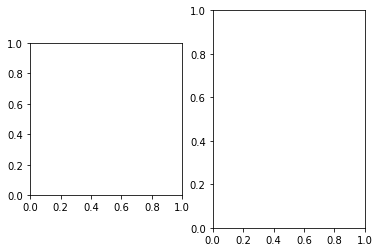

In [188]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot each pie chart in a separate subplot
ax1.pie(train_X.groupby(['MINORITY']).sum().reset_index())
ax2.pie(train_X.groupby(['GENDER']).sum().reset_index())
ax2.pie(train_X.groupby(['JOBCAT']).sum().reset_index())

plt.show()